In [28]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import interpolate

import sys
import os
current = os.path.dirname(os.path.realpath('Main_Programm.ipynb'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.pressure_conversion import pressure_conversion
from Ausgleichsbecken.Ausgleichsbecken_class_file import Ausgleichsbecken_class
from Druckrohrleitung.Druckrohrleitung_class_file import Druckrohrleitung_class
from Turbinen.Turbinen_class_file import Francis_Turbine
from Regler.Regler_class_file import PI_controller_class
from Kraftwerk.Kraftwerk_class_file import Kraftwerk_class

In [29]:
def interpolate_validation_data(x,y,t_vec):
    interpol_fun = interpolate.interp1d(x,y,'linear',fill_value='extrapolate')
    return(interpol_fun(t_vec))


In [37]:
# import validation data
validation_data_TB = pd.read_csv('Validation_data_TB.csv').set_index('Timestamp')
validation_data_UT = pd.read_csv('Validation_data_UT.csv').set_index('Timestamp')



validation_data = validation_data_UT.join(validation_data_TB,how='outer')
validation_data.sort_index()


comp_val_OL_M1_p    = pressure_conversion(validation_data['OL_T1_p'].to_numpy(copy=True),'bar','Pa')
comp_val_OL_M1_LA   = validation_data['OL_T1_LA'].to_numpy(copy=True)/100.
comp_val_OL_M2_p    = pressure_conversion(validation_data['OL_T2_p'].to_numpy(copy=True),'bar','Pa')
comp_val_OL_M2_LA   = validation_data['OL_T2_LA'].to_numpy(copy=True)/100.
comp_val_t_vec_TB   = validation_data.index.to_numpy(copy=True)    
comp_val_t_vec_TB   -= np.min(comp_val_t_vec_TB)

comp_val_OL_level   = validation_data['TB-Pegel'].to_numpy(copy=True)
comp_val_UL_M1_p    = pressure_conversion(validation_data['UL_T1_p'].to_numpy(copy=True),'bar','Pa')
comp_val_UL_M1_LA   = validation_data['UL_T1_LA'].to_numpy(copy=True)/100.
comp_val_UL_M2_p    = pressure_conversion(validation_data['UL_T2_p'].to_numpy(copy=True),'bar','Pa')
comp_val_UL_M2_LA   = validation_data['UL_T2_LA'].to_numpy(copy=True)/100.
comp_val_t_vec_UT   = validation_data.index.to_numpy(copy=True)
comp_val_t_vec_UT   -= np.min(comp_val_t_vec_UT)   



KeyError: "None of ['Timestamp'] are in the columns"

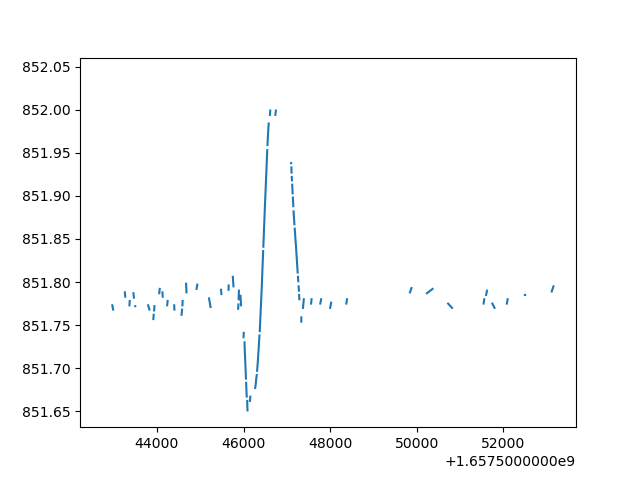

In [36]:
%matplotlib widget
plt.plot(validation_data_UT['TB-Pegel'])

In [7]:
# define constants

    # for physics
g                   = 9.81                                          # [m/s²]    gravitational acceleration 
rho                 = 1000.                                         # [kg/m³]   density of water 
pUnit_calc          = 'Pa'                                          # [string]    DO NOT CHANGE! for pressure conversion in print statements and plot labels 
pUnit_conv          = 'mWS'                                         # [string]    for pressure conversion in print statements and plot labels

    # for KW OL 
OL_T1_Q_nenn        = 0.85                                          # [m³/s]    nominal flux of turbine 
OL_T1_p_nenn        = pressure_conversion(10.6,'bar',pUnit_calc)    # [Pa]      nominal pressure of turbine 
OL_T1_closingTime   = 10.                                           # [s]       closing time of turbine

OL_T2_Q_nenn        = 0.85/2                                          # [m³/s]    nominal flux of turbine 
OL_T2_p_nenn        = pressure_conversion(10.6,'bar',pUnit_calc)    # [Pa]      nominal pressure of turbine 
OL_T2_closingTime   = 10.                                           # [s]       closing time of turbine

    # for KW UL
UL_T1_Q_nenn        = 0.85                                          # [m³/s]    nominal flux of turbine 
UL_T1_p_nenn        = pressure_conversion(10.6,'bar',pUnit_calc)    # [Pa]      nominal pressure of turbine 
UL_T1_closingTime   = 10.                                           # [s]       closing time of turbine

UL_T2_Q_nenn        = 0.85/2                                          # [m³/s]    nominal flux of turbine 
UL_T2_p_nenn        = pressure_conversion(10.6,'bar',pUnit_calc)    # [Pa]      nominal pressure of turbine 
UL_T2_closingTime   = 10.                                           # [s]       closing time of turbine

    # for PI controller
Con_targetLevel     = 6.                                            # [m]
Con_K_p             = 0.1                                           # [-]       proportional constant of PI controller
Con_T_i             = 1000.                                         # [s]       timespan in which a steady state error is corrected by the intergal term
Con_deadbandRange   = 0.05                                          # [m]       Deadband range around targetLevel for which the controller does NOT intervene

    # for pipeline
Pip_length          = (535.+478.)                                   # [m]       length of pipeline
Pip_dia             = 0.9                                           # [m]       diameter of pipeline
Pip_area            = Pip_dia**2/4*np.pi                            # [m²]      crossectional area of pipeline
Pip_head            = 105.                                          # [m]       hydraulic head of pipeline without reservoir
Pip_angle           = np.arcsin(Pip_head/Pip_length)                # [rad]     elevation angle of pipeline 
Pip_n_seg           = 50                                            # [-]       number of pipe segments in discretization
Pip_f_D             = 0.014                                         # [-]       Darcy friction factor
Pip_pw_vel          = 500.                                          # [m/s]     propagation velocity of the pressure wave (pw) in the given pipeline
    # derivatives of the pipeline constants
Pip_dx              = Pip_length/Pip_n_seg                          # [m]       length of each pipe segment
Pip_dt              = Pip_dx/Pip_pw_vel                             # [s]       timestep according to method of characteristics
Pip_nn              = Pip_n_seg+1                                   # [1]       number of nodes
Pip_x_vec           = np.arange(0,Pip_nn,1)*Pip_dx                  # [m]       vector holding the distance of each node from the upstream reservoir along the pipeline
Pip_h_vec           = np.arange(0,Pip_nn,1)*Pip_head/Pip_n_seg      # [m]       vector holding the vertival distance of each node from the upstream reservoir

    # for reservoir
Res_area_base       = 74.                                           # [m²]      total base are of the cuboid reservoir   
Res_area_out        = Pip_area                                      # [m²]      outflux area of the reservoir, given by pipeline area
Res_level_crit_lo   = 0.                                            # [m]       for yet-to-be-implemented warnings
Res_level_crit_hi   = np.inf                                        # [m]       for yet-to-be-implemented warnings
Res_dt_approx       = 1e-3                                          # [s]       approx. timestep of reservoir time evolution to ensure numerical stability (see Res_nt why approx.)
Res_nt              = max(1,int(Pip_dt//Res_dt_approx))             # [1]       number of timesteps of the reservoir time evolution within one timestep of the pipeline
Res_dt              = Pip_dt/Res_nt                                 # [s]       harmonised timestep of reservoir time evolution

    # for general simulation
flux_init           = (OL_T1_Q_nenn+OL_T2_Q_nenn)/1.1                                # [m³/s]    initial flux through whole system for steady state initialization  
level_init          = Con_targetLevel                               # [m]       initial water level in upstream reservoir for steady state initialization
simTime_target      = np.max(comp_val_t_vec_UT)                     # [s]       target for total simulation time (will vary slightly to fit with Pip_dt)
nt                  = int(simTime_target//Pip_dt)                   # [1]       Number of timesteps of the whole system
t_vec               = np.arange(0,nt+1,1)*Pip_dt                    # [s]       time vector. At each step of t_vec the system parameters are stored


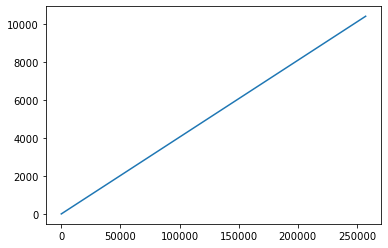

In [8]:
plt.plot(t_vec)

In [9]:
# import validation data
val_OL_M1_p    = interpolate_validation_data(comp_val_t_vec_TB,comp_val_OL_M1_p,t_vec)
val_OL_M1_LA   = interpolate_validation_data(comp_val_t_vec_TB,comp_val_OL_M1_LA,t_vec)
val_OL_M2_p    = interpolate_validation_data(comp_val_t_vec_TB,comp_val_OL_M2_p,t_vec)
val_OL_M2_LA   = interpolate_validation_data(comp_val_t_vec_TB,comp_val_OL_M2_LA,t_vec)
val_OL_level   = interpolate_validation_data(comp_val_t_vec_UT,comp_val_OL_level,t_vec)
val_UL_M1_p    = interpolate_validation_data(comp_val_t_vec_UT,comp_val_UL_M1_p,t_vec)
val_UL_M1_LA   = interpolate_validation_data(comp_val_t_vec_UT,comp_val_UL_M1_LA,t_vec)
val_UL_M2_p    = interpolate_validation_data(comp_val_t_vec_UT,comp_val_UL_M2_p,t_vec)
val_UL_M2_LA   = interpolate_validation_data(comp_val_t_vec_UT,comp_val_UL_M2_LA,t_vec)



In [ ]:
# create objects

# downstream turbines
UL_T1 = Francis_Turbine(UL_T1_Q_nenn,UL_T1_p_nenn,UL_T1_closingTime,Pip_dt,pUnit_conv)
UL_T2 = Francis_Turbine(UL_T2_Q_nenn,UL_T2_p_nenn,UL_T2_closingTime,Pip_dt,pUnit_conv)

KW_UL = Kraftwerk_class()
KW_UL.add_turbine(UL_T1)
KW_UL.add_turbine(UL_T2)

KW_UL.set_steady_state_by_LA(LA_vec=[val_UL_M1_LA[0],val_UL_M2_LA[0]],ss_pressure=np.max([val_UL_M1_p,val_UL_M2_p])) 
flux_init = KW_UL.get_current_Q()

# Upstream reservoir
reservoir = Ausgleichsbecken_class(Res_area_base,Res_area_out,Res_dt,pUnit_conv,Res_level_crit_lo,Res_level_crit_hi,rho)
reservoir.set_steady_state(flux_init,level_init)

# pipeline
pipe = Druckrohrleitung_class(Pip_length,Pip_dia,Pip_head,Pip_n_seg,Pip_f_D,Pip_pw_vel,Pip_dt,pUnit_conv,rho)
pipe.set_steady_state(flux_init,reservoir.get_current_pressure())

# influx setting turbines
OL_T1 = Francis_Turbine(OL_T1_Q_nenn,OL_T1_p_nenn,OL_T1_closingTime,Pip_dt,pUnit_conv)
OL_T2 = Francis_Turbine(OL_T2_Q_nenn,OL_T2_p_nenn,OL_T2_closingTime,Pip_dt,pUnit_conv)

KW_OL = Kraftwerk_class()
KW_OL.add_turbine(OL_T1)
KW_OL.add_turbine(OL_T2)

KW_OL.set_steady_state_by_LA(LA_vec=[val_OL_M1_LA[0],val_OL_M2_LA[0]],ss_pressure=np.max([val_OL_M1_p,val_OL_M2_p])) 


In [ ]:
# initialization for Timeloop

# pipeline
v_old = pipe.get_current_velocity_distribution()                # storing the velocity from the last timestep
v_min = pipe.get_lowest_velocity_per_node()                     # storing minimal flux velocity at each node
v_max = pipe.get_highest_velocity_per_node()                    # storing maximal flux velocity at each node
Q_old = pipe.get_current_flux_distribution()                    # storing the flux from the last timestep
Q_min = pipe.get_lowest_flux_per_node()                         # storing minimal flux at each node
Q_max = pipe.get_highest_flux_per_node()                        # storing maximal flux at each node
p_old = pipe.get_current_pressure_distribution()                # storing the pressure from the last timestep
p_min = pipe.get_lowest_pressure_per_node()                     # storing minimal pressure at each node
p_max = pipe.get_highest_pressure_per_node()                    # storing maximal pressure at each node
p_0   = pipe.get_initial_pressure_distribution()                # storing initial pressure at each node

v_boundary_res  = np.zeros_like(t_vec)                          # storing the boundary velocity at the reservoir
v_boundary_tur  = np.zeros_like(t_vec)                          # storing the boundary velocity at the turbine
Q_boundary_res  = np.zeros_like(t_vec)                          # storing the boundary flux at the reservoir
Q_boundary_tur  = np.zeros_like(t_vec)                          # storing the boundary flux at the turbine
p_boundary_res  = np.zeros_like(t_vec)                          # storing the boundary pressure at the reservoir
p_boundary_tur  = np.zeros_like(t_vec)                          # storing the boundary pressure at the turbine

v_boundary_res[0] = v_old[0]                                    # storing the initial value for the boundary velocity at the reservoir
v_boundary_tur[0] = v_old[-1]                                   # storing the initial value for the boundary velocity at the turbine
Q_boundary_res[0] = Q_old[0]                                    # storing the initial value for the boundary flux at the reservoir
Q_boundary_tur[0] = Q_old[-1]                                   # storing the initial value for the boundary flux at the turbine
p_boundary_res[0] = p_old[0]                                    # storing the initial value for the boundary pressure at the reservoir
p_boundary_tur[0] = p_old[-1]                                   # storing the initial value for the boundary pressure at the turbine

# reservoir
Q_in_vec = np.zeros_like(t_vec)                                 # storing the influx to the reservoir
Q_in_vec[0] = flux_init                                         # storing the initial influx to the reservoir
# Outflux from reservoir is stored in Q_boundary_res
level_vec  = np.zeros_like(t_vec)                               # storing the level in the reservoir at the end of each pipeline timestep
level_vec[0] = level_init                                       # storing the initial level in the reservoir
volume_vec = np.zeros_like(t_vec)                               # storing the volume in the reservoir at the end of each pipeline timestep
volume_vec[0] = reservoir.get_current_volume()                  # storing the initial volume in the reservoir

# OL KW
    # manual input to modulate influx
OL_T1_LA_soll_vec = val_OL_M1_LA

OL_T2_LA_soll_vec = val_OL_M2_LA                                # storing the target value for the guide van opening

OL_T1_LA_ist_vec = np.zeros_like(t_vec)                         # storing the actual value of the guide vane opening
OL_T1_LA_ist_vec[0] = OL_T1.get_current_LA()                    # storing the initial value of the guide vane opening

OL_T2_LA_ist_vec = np.zeros_like(t_vec)                         # storing the actual value of the guide vane opening
OL_T2_LA_ist_vec[0] = OL_T2.get_current_LA()                    # storing the initial value of the guide vane opening

# UL KW
UL_T1_LA_soll_vec = val_UL_M1_LA                                # storing the target value of the guide vane opening
UL_T1_LA_soll_vec[0] = UL_T1.get_current_LA()                   # storing the initial value of the guide vane opening

UL_T2_LA_soll_vec = val_UL_M2_LA                                # storing the target value of the guide vane opening

UL_T1_LA_ist_vec = np.zeros_like(t_vec)                         # storing the actual value of the guide vane opening
UL_T1_LA_ist_vec[0] = UL_T1.get_current_LA()                    # storing the initial value of the guide vane opening

UL_T2_LA_ist_vec = np.zeros_like(t_vec)                         # storing the actual value of the guide vane opening
UL_T2_LA_ist_vec[0] = UL_T2.get_current_LA()                    # storing the initial value of the guide vane opening


In [ ]:
%matplotlib qt5


fig1,axs1 = plt.subplots(3,1)
fig1.suptitle(str(0) +' s / '+str(round(t_vec[-1],2)) + ' s' )
axs1[0].set_title('Pressure distribution in pipeline')
axs1[0].set_xlabel(r'$x$ [$\mathrm{m}$]')
axs1[0].set_ylabel(r'$p$ ['+pUnit_conv+']')
axs1[1].set_title('Pressure distribution in pipeline \n Difference to t=0')
axs1[1].set_xlabel(r'$x$ [$\mathrm{m}$]')
axs1[1].set_ylabel(r'$p$ ['+pUnit_conv+']')
axs1[2].set_title('Flux distribution in pipeline')
axs1[2].set_xlabel(r'$x$ [$\mathrm{m}$]')
axs1[2].set_ylabel(r'$Q$ [$\mathrm{m}^3 / \mathrm{s}$]')
lo_0,       = axs1[0].plot(Pip_x_vec,pressure_conversion(p_old,pUnit_calc, pUnit_conv),marker='.')
lo_0min,    = axs1[0].plot(Pip_x_vec,pressure_conversion(pipe.get_lowest_pressure_per_node(),pUnit_calc,pUnit_conv),c='red')
lo_0max,    = axs1[0].plot(Pip_x_vec,pressure_conversion(pipe.get_highest_pressure_per_node(),pUnit_calc,pUnit_conv),c='red')
lo_1,       = axs1[1].plot(Pip_x_vec,pressure_conversion(p_old-p_0,pUnit_calc, pUnit_conv),marker='.')
lo_1min,    = axs1[1].plot(Pip_x_vec,pressure_conversion(pipe.get_lowest_pressure_per_node()-p_0,pUnit_calc,pUnit_conv),c='red')
lo_1max,    = axs1[1].plot(Pip_x_vec,pressure_conversion(pipe.get_highest_pressure_per_node()-p_0,pUnit_calc,pUnit_conv),c='red')
lo_2,       = axs1[1].plot(Pip_x_vec,Q_old,marker='.')
lo_2min,    = axs1[2].plot(Pip_x_vec,pipe.get_lowest_flux_per_node(),c='red')
lo_2max,    = axs1[2].plot(Pip_x_vec,pipe.get_highest_flux_per_node(),c='red')

# axs1[0].autoscale()
# axs1[1].autoscale()

fig1.tight_layout()
fig1.show()
plt.pause(1)


In [ ]:
# needed for turbine convergence
convergence_parameters = [p_old[-2],v_old[-2],Pip_dia,Pip_area,Pip_angle,Pip_f_D,Pip_pw_vel,rho,Pip_dt,p_old[-1]]

# loop through time steps of the pipeline
for it_pipe in range(1,nt+1):

    KW_OL.update_LAs([OL_T1_LA_soll_vec[it_pipe],OL_T2_LA_soll_vec[it_pipe]])
    KW_OL.set_pressure(OL_T1_p_nenn)
    Q_in_vec[it_pipe] = KW_OL.get_current_Q()
    reservoir.set_influx(Q_in_vec[it_pipe])

# for each pipeline timestep, execute Res_nt timesteps of the reservoir code
    # set initial condition for the reservoir time evolution calculted with the timestep_reservoir_evolution() method
    reservoir.set_pressure(p_old[0],display_warning=False)
    reservoir.set_outflux(Q_old[0],display_warning=False)
    # calculate the time evolution of the reservoir level within each pipeline timestep to avoid runaway numerical error
    for it_res in range(Res_nt):
        reservoir.timestep_reservoir_evolution()                                                             
    level_vec[it_pipe]  = reservoir.get_current_level()                                                 
    volume_vec[it_pipe] = reservoir.get_current_volume()                                                 
    
    # change the guide vane opening based on the target value and closing time limitation
    KW_UL.update_LAs([UL_T1_LA_soll_vec[it_pipe],UL_T2_LA_soll_vec[it_pipe]])
    OL_T1_LA_ist_vec[it_pipe], OL_T2_LA_ist_vec[it_pipe] = KW_OL.get_current_LAs()
    UL_T1_LA_ist_vec[it_pipe], UL_T2_LA_ist_vec[it_pipe] = KW_UL.get_current_LAs()

    # set boundary condition for the next timestep of the characteristic method
    convergence_parameters[0] = p_old[-2]
    convergence_parameters[1] = v_old[-2]
    convergence_parameters[9] = p_old[-1]
    KW_UL.set_pressure(p_old[-1])
    KW_UL.converge(convergence_parameters)
    p_boundary_res[it_pipe] = reservoir.get_current_pressure()
    v_boundary_tur[it_pipe] = 1/Pip_area*KW_UL.get_current_Q()
    Q_boundary_tur[it_pipe] = KW_UL.get_current_Q()

    # the the boundary condition in the pipe.object and thereby calculate boundary pressure at turbine
    pipe.set_boundary_conditions_next_timestep(p_boundary_res[it_pipe],v_boundary_tur[it_pipe])
    # pipe.v[0] = (0.8*pipe.v[0]+0.2*reservoir.get_current_outflux()/Res_area_out) # unnecessary
    p_boundary_tur[it_pipe] = pipe.get_current_pressure_distribution()[-1]
    v_boundary_res[it_pipe] = pipe.get_current_velocity_distribution()[0]
    Q_boundary_res[it_pipe] = pipe.get_current_flux_distribution()[0]

    # perform the next timestep via the characteristic method
    pipe.timestep_characteristic_method_vectorized()

    # prepare for next loop
    p_old = pipe.get_current_pressure_distribution()
    v_old = pipe.get_current_velocity_distribution()
    Q_old = pipe.get_current_flux_distribution()

    # plot some stuff
        # remove line-objects to autoscale axes (there is definetly a better way, but this works ¯\_(ツ)_/¯ )
    if it_pipe%25 == 0:
        lo_0.remove()
        lo_0min.remove()
        lo_0max.remove()
        lo_1.remove()
        lo_1min.remove()
        lo_1max.remove()
        lo_2.remove()
        lo_2min.remove()
        lo_2max.remove()
            # plot new pressure and velocity distribution in the pipeline
        lo_0, = axs1[0].plot(Pip_x_vec,pressure_conversion(pipe.get_current_pressure_distribution(),pUnit_calc,pUnit_conv),marker='.',c='blue')
        lo_0min, = axs1[0].plot(Pip_x_vec,pressure_conversion(pipe.get_lowest_pressure_per_node(),pUnit_calc,pUnit_conv),c='red')
        lo_0max, = axs1[0].plot(Pip_x_vec,pressure_conversion(pipe.get_highest_pressure_per_node(),pUnit_calc,pUnit_conv),c='red')        
        lo_1, = axs1[1].plot(Pip_x_vec,pressure_conversion(pipe.get_current_pressure_distribution()-p_0,pUnit_calc,pUnit_conv),marker='.',c='blue')
        lo_1min, = axs1[1].plot(Pip_x_vec,pressure_conversion(pipe.get_lowest_pressure_per_node()-p_0,pUnit_calc,pUnit_conv),c='red')
        lo_1max, = axs1[1].plot(Pip_x_vec,pressure_conversion(pipe.get_highest_pressure_per_node()-p_0,pUnit_calc,pUnit_conv),c='red')
        lo_2, = axs1[2].plot(Pip_x_vec,pipe.get_current_flux_distribution(),marker='.',c='blue')
        lo_2min, = axs1[2].plot(Pip_x_vec,pipe.get_lowest_flux_per_node(),c='red')
        lo_2max, = axs1[2].plot(Pip_x_vec,pipe.get_highest_flux_per_node(),c='red')
        fig1.suptitle(str(round(t_vec[it_pipe],2))+ ' s / '+str(round(t_vec[-1],2)) + ' s' )
        fig1.canvas.draw()
        fig1.tight_layout()
        fig1.show()
        plt.pause(0.00000001)     

In [ ]:
fig2,axs2 = plt.subplots(1,1)
axs2.set_title('Level and Volume reservoir')
axs2.plot(t_vec,level_vec,label='level')
axs2.set_xlabel(r'$t$ [$\mathrm{s}$]')
axs2.set_ylabel(r'$h$ [m]')
x_twin_00 = axs2.twinx()
x_twin_00.set_ylabel(r'$V$ [$\mathrm{m}^3$]')
x_twin_00.plot(t_vec,volume_vec)
axs2.legend()

fig2,axs2 = plt.subplots(1,1)
axs2.set_title('LA')
axs2.plot(t_vec,100*OL_T1_LA_soll_vec,label='OL_T1 Target',c='b')
axs2.scatter(t_vec[::200],100*OL_T1_LA_ist_vec[::200],label='OL_T1 Actual',c='b',marker='+')
axs2.plot(t_vec,100*OL_T2_LA_soll_vec,label='OL_T2 Target',c='g')
axs2.scatter(t_vec[::200],100*OL_T2_LA_ist_vec[::200],label='OL_T2 Actual',c='g',marker='+')
axs2.plot(t_vec,100*UL_T1_LA_soll_vec,label='UL_T1 Target',c='r')
axs2.scatter(t_vec[::200],100*UL_T1_LA_ist_vec[::200],label='UL_T1 Actual',c='r',marker='+')
axs2.plot(t_vec,100*UL_T2_LA_soll_vec,label='UL_T2 Target',c='k')
axs2.scatter(t_vec[::200],100*UL_T2_LA_ist_vec[::200],label='UL_T2 Actual',c='k',marker='+')
axs2.set_xlabel(r'$t$ [$\mathrm{s}$]')
axs2.set_ylabel(r'$LA$ [%]')
axs2.legend()

fig2,axs2 = plt.subplots(1,1)
axs2.set_title('Pressure change vs t=0 at reservoir and turbine')
axs2.plot(t_vec,pressure_conversion(p_boundary_res-p_boundary_res[0],pUnit_calc, pUnit_conv),label='Reservoir')
axs2.plot(t_vec,pressure_conversion(p_boundary_tur-p_boundary_tur[0],pUnit_calc, pUnit_conv),label='Turbine')
axs2.set_xlabel(r'$t$ [$\mathrm{s}$]')
axs2.set_ylabel(r'$p$ ['+pUnit_conv+']')
axs2.legend()

fig2,axs2 = plt.subplots(1,1)
axs2.set_title('Fluxes')
axs2.plot(t_vec,Q_in_vec,label='Influx')
axs2.plot(t_vec,Q_boundary_res,label='Outflux')
axs2.scatter(t_vec[::200],Q_boundary_tur[::200],label='Flux Turbine',c='g',marker='+')
axs2.set_xlabel(r'$t$ [$\mathrm{s}$]')
axs2.set_ylabel(r'$Q$ [$\mathrm{m}^3/\mathrm{s}$]')
axs2.legend()

# fig2,axs2 = plt.subplots(1,1)
# axs2.set_title('Min and Max Pressure')
# axs2.plot(Pip_x_vec,pipe.get_lowest_pressure_per_node(disp_flag=True),c='red')
# axs2.plot(Pip_x_vec,pipe.get_highest_pressure_per_node(disp_flag=True),c='red')
# axs2.set_xlabel(r'$x$ [$\mathrm{m}$]')
# axs2.set_ylabel(r'$p$ ['+pUnit_conv+']')

# fig2,axs2 = plt.subplots(1,1)
# axs2.set_title('Min and Max Fluxes')
# axs2.plot(Pip_x_vec,pipe.get_lowest_flux_per_node(),c='red')
# axs2.plot(Pip_x_vec,pipe.get_highest_flux_per_node(),c='red')
# axs2.set_xlabel(r'$x$ [$\mathrm{m}$]')
# axs2.set_ylabel(r'$Q$ [$\mathrm{m}^3/\mathrm{s}$]')


fig2.tight_layout()
plt.show()

In [ ]:
fig3,axs3 = plt.subplots(2,2)
axs3[0,0].set_title('Level and Volume reservoir')
axs3[0,0].plot(t_vec,level_vec,label='level')
axs3[0,0].set_xlabel(r'$t$ [$\mathrm{s}$]')
axs3[0,0].set_ylabel(r'$h$ [m]')
x_twin_00 = axs3[0,0].twinx()
x_twin_00.set_ylabel(r'$V$ [$\mathrm{m}^3$]')
x_twin_00.plot(t_vec,volume_vec)
axs3[0,0].legend()

axs3[0,1].set_title('LA')
axs3[0,1].plot(t_vec,100*OL_T1_LA_soll_vec,label='OL_T1 Target',c='b')
axs3[0,1].scatter(t_vec[::200],100*OL_T1_LA_ist_vec[::200],label='OL_T1 Actual',c='b',marker='+')
axs3[0,1].plot(t_vec,100*OL_T2_LA_soll_vec,label='OL_T2 Target',c='g')
axs3[0,1].scatter(t_vec[::200],100*OL_T2_LA_ist_vec[::200],label='OL_T2 Actual',c='g',marker='+')
axs3[0,1].plot(t_vec,100*UL_T1_LA_soll_vec,label='UL_T1 Target',c='r')
axs3[0,1].scatter(t_vec[::200],100*UL_T1_LA_ist_vec[::200],label='UL_T1 Actual',c='r',marker='+')
axs3[0,1].plot(t_vec,100*UL_T2_LA_soll_vec,label='UL_T2 Target',c='k')
axs3[0,1].scatter(t_vec[::200],100*UL_T2_LA_ist_vec[::200],label='UL_T2 Actual',c='k',marker='+')
axs3[0,1].set_xlabel(r'$t$ [$\mathrm{s}$]')
axs3[0,1].set_ylabel(r'$LA$ [%]')
axs3[0,1].legend()

axs3[1,0].set_title('Fluxes')
axs3[1,0].plot(t_vec,Q_in_vec,label='Influx')
axs3[1,0].plot(t_vec,Q_boundary_res,label='Outflux')
axs3[1,0].scatter(t_vec[::200],Q_boundary_tur[::200],label='Flux Turbine',c='g',marker='+')
axs3[1,0].set_xlabel(r'$t$ [$\mathrm{s}$]')
axs3[1,0].set_ylabel(r'$Q$ [$\mathrm{m}^3/\mathrm{s}$]')
axs3[1,0].legend()

axs3[1,1].set_title('Pressure change vs t=0 at reservoir and turbine')
axs3[1,1].plot(t_vec,pressure_conversion(p_boundary_res-p_boundary_res[0],pUnit_calc, pUnit_conv),label='Reservoir')
axs3[1,1].plot(t_vec,pressure_conversion(p_boundary_tur-p_boundary_tur[0],pUnit_calc, pUnit_conv),label='Turbine')
axs3[1,1].set_xlabel(r'$t$ [$\mathrm{s}$]')
axs3[1,1].set_ylabel(r'$p$ ['+pUnit_conv+']')
axs3[1,1].legend()

fig3.tight_layout()
plt.show()

In [ ]:
figure = plt.figure()
plt.plot(t_vec,pressure_conversion(p_boundary_tur,'Pa','mWS'))
plt.plot(t_vec,pressure_conversion(val_p_vec,'Pa','mWS'),marker='+')